# DINN Tutorial --- COVID

## This notebook will show the entire process of training a neural network to learn a disease

## Consider the following system of differential equations

dS/dt = - (alpha / N)  S  I

dI/dt = (alpha / N)  S  I - beta  I - gamma  I 

dD/dt = gamma  I

dR/dt = beta  I


Where 

beta = “effective/apparent” per day recovery rates

gamma = “effective/apparent” per day fatality rates

alpha = infection rate

N = population size

## This system represents a COVID model and has 4 compartments: susceptible, infected, dead, and recovered

## Since we don't have actual data from the environment to work with, we will generate it

# Import libraries for generating & visualizing the data

In [17]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## We start by setting some information that we got from the literature

In [27]:
# A grid of time points (in days)
t = np.linspace(0, 500, 100) #from day 0 to day 500, generate 100 points

# Initial conditions (example values)
N = 1.4e9  # Total population
I0 = 1e4  # Initial infected cases
A0 = 0.3 * I0  # Initial asymptomatic cases (30% of initial infections)
R0 = 0  # Initial recovered cases
D0 = 0  # Initial deceased cases
# S0 = N - I0 - A0 - R0 - D0  # Initial susceptible population
S0 = 1e6

# Initial state
y0 = [S0, A0, I0, R0, D0]

# Parameters (example values, adjust based on estimates)
Lambda = 0  # No birth rate considered in this example
beta1 = 0.2
beta2 = 0.3
gamma1 = 0.1
gamma2 = 0.05
gamma3 = 0.01
kappa1 = 0.02
kappa2 = 0.01
mu = 0.0001  # Natural death rate

## We then write out the system of equations in a function that will calculate the value of each compartment at each time step (e.g day)

In [28]:
# The SIR model differential equations.
def deriv(y, t, Lambda, beta1, beta2, gamma1, gamma2, gamma3, kappa1, kappa2, mu):
    S, A, I, R, D = y
    
    # Define the system of differential equations
    dS_dt = Lambda - beta1 * S * A - beta2 * S * I - mu * S
    dA_dt = beta1 * S * A - (gamma1 + gamma2 + gamma3) * A - mu * A
    dI_dt = beta2 * S * I + gamma1 * A - (kappa1 + kappa2) * I - mu * I
    dR_dt = gamma2 * A + kappa1 * I - mu * R
    dD_dt = gamma3 * A + kappa2 * I
    
    return [dS_dt, dA_dt, dI_dt, dR_dt, dD_dt]

## And then we pass the initial conditions to the function to get the values of each compartment for the length we chose before (500 days, 100 data points per compartment)

In [29]:
# Initial conditions vector
# y0 = S0, I0, D0, R0
# Integrate the SIR equations over the time grid, t.
solution = odeint(deriv, y0, t, args=(Lambda, beta1, beta2, gamma1, gamma2, gamma3, kappa1, kappa2, mu))
S, A, I, R, D = solution.T

## We can now plot the results

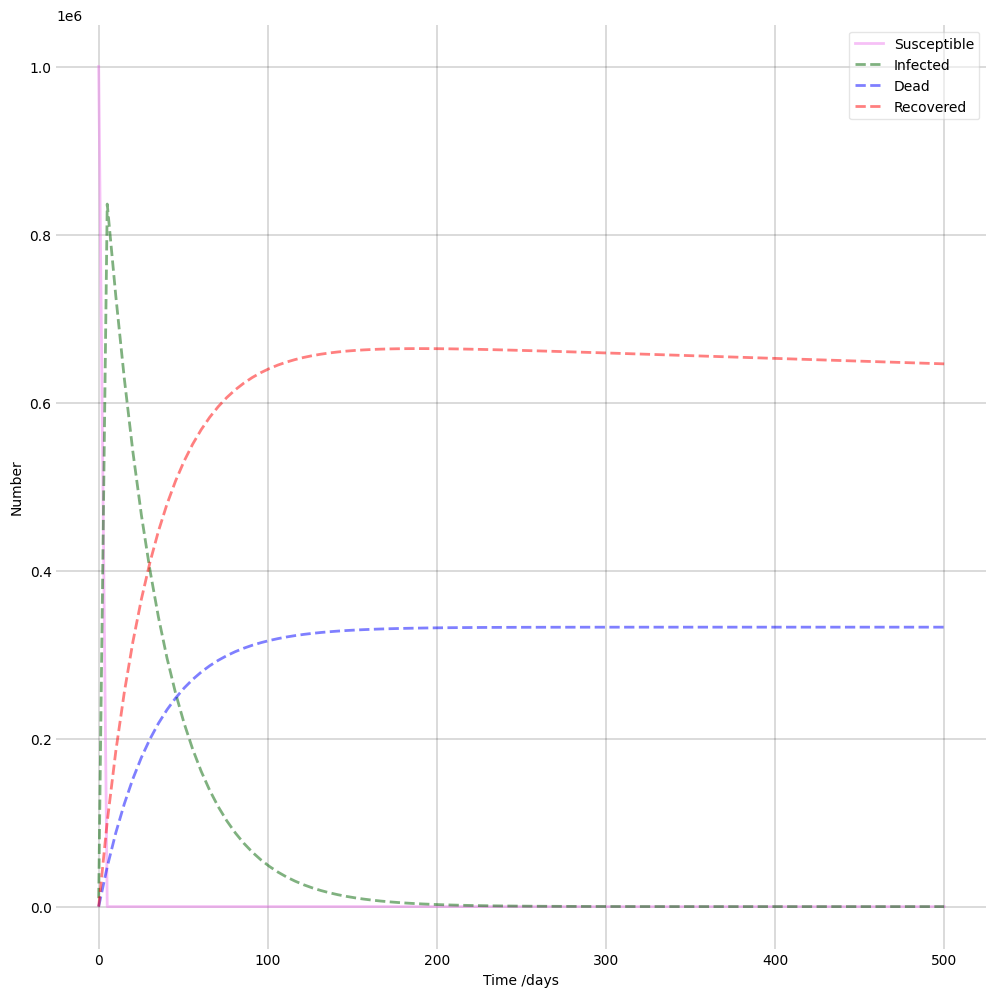

In [30]:
# Plot the data
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.plot(t, S, 'violet', alpha=0.5, lw=2, label='Susceptible', linestyle='solid')
ax.plot(t, I, 'darkgreen', alpha=0.5, lw=2, label='Infected', linestyle='dashed')
ax.plot(t, D, 'blue', alpha=0.5, lw=2, label='Dead', linestyle='dashed')
ax.plot(t, R, 'red', alpha=0.5, lw=2, label='Recovered', linestyle='dashed')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(visible=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## And to save the results as a csv file

In [31]:
#save to csv file
COVID_Data = np.asarray([t, S, A, I, D, R]) 

np.savetxt("COVID_Tutorial.csv", COVID_Data, delimiter=",")

## Great! Now we have data to work with. On to training a neural network.
I will break down the entire training process into parts. These parts might NOT be runnable on their own (meaning, you can't run the code -- which is why I will comment them out). The point is, I think that it will be easier to understand the process by first understanding what each part is doing, and then seeing how they all work together

## 1. Import libraries

In [32]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

torch.manual_seed(1234) #set seed (optional)

## 2. Load the data

In [33]:
covid_data = genfromtxt('COVID_Tutorial.csv', delimiter=',') #in the form of [t, S, A, I, D, R]

## 3. Define the class

In [35]:
class DINN(nn.Module):
    def __init__(self, t, S_data, A_data, I_data, D_data, R_data): # remember that the data was saved as [t,S,I,D,R]
        super(DINN, self).__init__()
        # here all the "loading the data" and training is happening
        pass

## 4. Now we need to define some initial conditions

In [36]:
class DINN(nn.Module):
    def __init__(self, t, S_data, A_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        
        self.N = 1.4e9 #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.A = torch.tensor(A_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = [] # here I saved the model's losses per epoch

## 5. There are two options for this part. Either you know the values of the parameters (alpha, beta, gamma) or you don't. 
If you're wondering how can we not know their values if we just generated the data using them, remember that we can also get the data from the environment, and so we might not have the parameters

## If we don't know their values, we let the neural network learn it
Note that the reason for the "tilda" part will be clear soon. It's basically to bound the variables around a certain range (imagine telling the neural network to learn alpha, but not from negative infinity to infinity, but from -100 to 100)

In [11]:
# self.alpha_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
# self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
# self.gamma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))

## If we do know their values, we just set it

In [12]:
# self.alpha_tilda = torch.tensor(0.191)
# self.beta_tilda = torch.tensor(0.05)
# self.gamma_tilda = torch.tensor(0.0294)

## Let's assume we don't know them:

In [37]:
class DINN(nn.Module):
    def __init__(self, t, S_data, A_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        
        self.N = 1.4e9 #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.A = torch.tensor(A_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = [] # here I saved the model's losses per epoch
        Lambda, beta1, beta2, gamma1, gamma2, gamma3, kappa1, kappa2, mu
        #setting the parameters
        self.Lambda_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))

## 6. Normalize the data
Remember that our population size was 59 mil? Remember that there was only 1 infected person and almost 59 mil susceptible people? These drastic variations in values are quite challenging for the network to learn. So we normalize each compartment to be between 0 and 1 for the sake of training

In [14]:
# find values for normalization

# max values
# self.S_max = max(self.S)
# self.I_max = max(self.I)
# self.D_max = max(self.D)
# self.R_max = max(self.R)

# min values
# self.S_min = min(self.S)
# self.I_min = min(self.I)
# self.D_min = min(self.D)
# self.R_min = min(self.R)

# create new normalized parameters (which is why the "hat" parts)
# self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
# self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
# self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
# self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)


In [38]:
class DINN(nn.Module):
    def __init__(self, t, S_data, A_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        
        self.N = 1.4e9 #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.A = torch.tensor(A_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = [] # here I saved the model's losses per epoch

        #setting the parameters
        self.Lambda_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))

        #find values for normalization
        self.S_max = max(self.S)
        self.A_max = max(self.A)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.A_min = min(self.A)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.A_hat = (self.A - self.A_min) / (self.A_max - self.A_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)        

## 7. A bit "hacky" way to calculate the gradients later
It doesn't seem like PyTorch has an easy way to calculate gradients. The issue is that "grad" only knows how to propagate gradients from a scalar tensor (which our network's output is not), which is why I had to calculate the Jacobian.
So instead of calculating the entire jacobian, I'm using this "hacky" way
 

In [16]:
# matrices (x4 for S,I,D,R) for the gradients
# What's important here:
# We have 4 compartments, hence the value 4 in "torch.zeros((len(self.t), 4))". 
# If we had 20 compartments we would write torch.zeros((len(self.t), 20))
# Also, we're setting each specific column in the formed matrices to 1

# self.m1 = torch.zeros((len(self.t), 4)); self.m1[:, 0] = 1
# self.m2 = torch.zeros((len(self.t), 4)); self.m2[:, 1] = 1
# self.m3 = torch.zeros((len(self.t), 4)); self.m3[:, 2] = 1
# self.m4 = torch.zeros((len(self.t), 4)); self.m4[:, 3] = 1

# See (https://stackoverflow.com/questions/67472361/using-pytorchs-autograd-efficiently-with-tensors-by-calculating-the-jacobian) for more details

In [39]:
class DINN(nn.Module):
    def __init__(self, t, S_data, A_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        
        self.N = 1.4e9 #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.A = torch.tensor(A_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = [] # here I saved the model's losses per epoch

        #setting the parameters
        self.Lambda_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))

        #find values for normalization
        self.S_max = max(self.S)
        self.A_max = max(self.A)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.A_min = min(self.A)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.A_hat = (self.A - self.A_min) / (self.A_max - self.A_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)        

        #matrices (x4 for S,A,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 5)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 5)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 5)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 5)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 5)); self.m5[:, 4] = 1

## 8. Let's initialize the network and learnable parameters

In [18]:
# # Initializing the neural network
# self.net_sidr = self.Net_sidr()

# # adding the parameters (alpha, beta, gamma) to the list of learnable parameters (basically, without this part only the neural network's weights will be updated, so we're telling the model to learn alpha, beta, and gamma as well)
# self.params = list(self.net_sidr.parameters())
# self.params.extend(list([self.alpha_tilda, self.beta_tilda, self.gamma_tilda]))

In [40]:
class DINN(nn.Module):
    def __init__(self, t, S_data, A_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        
        self.N = 1.4e9 #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.A = torch.tensor(A_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = [] # here I saved the model's losses per epoch

        #setting the parameters
        self.Lambda_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))

        #find values for normalization
        self.S_max = max(self.S)
        self.A_max = max(self.A)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.A_min = min(self.A)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.A_hat = (self.A - self.A_min) / (self.A_max - self.A_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)        

        #matrices (x4 for S,A,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 5)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 5)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 5)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 5)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 5)); self.m5[:, 4] = 1

        #NN
        self.net_saidr = self.Net_saidr()
        self.params = list(self.net_saidr.parameters())
        self.params.extend(list([self.Lambda_tilda,self.beta1_tilda,self.beta2_tilda,self.gamma1_tilda,self.gamma2_tilda,self.gamma3_tilda,self.kappa1_tilda,self.kappa2_tilda,self.mu_tilda]))


## 9. Forcing the parameters to be in a certain range
As I mentioned before, we could let the model learn the parameters from negative infinity to infinity, but why should we? These parameters usually have some plausible range. Here we force these ranges

In [20]:
#force parameters to be in the range of (-1, 1)
@property
def alpha(self):
    return torch.tanh(self.alpha_tilda) 

@property
def beta(self):
    return torch.tanh(self.beta_tilda) 

@property
def gamma(self):
    return torch.tanh(self.gamma_tilda) 


#note that you can easily play with that:

#force parameters to be in various ranges
@property
def alpha(self):
    return torch.tanh(self.alpha_tilda) * 0.5 # range of (-0.5, 0.5)

@property
def beta(self):
    return torch.tanh(self.beta_tilda) * 0.01 + 1 # range of (-0.99, 1.01)

@property
def gamma(self):
    return torch.tanh(self.gamma_tilda) * 100 # range of (-100, 100)


# Also note that we call these alpha, beta, and gamma (in comparison to "alpha_tilda", etc. from before)

# If you know the values of the parameters you just need to change this to:
@property
def alpha(self):
    return self.alpha_tilda

@property
def beta(self):
    return self.beta_tilda

@property
def gamma(self):
    return self.gamma_tilda

In [41]:
class DINN(nn.Module):
    def __init__(self, t, S_data, A_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        
        self.N = 1.4e9 #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.A = torch.tensor(A_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = [] # here I saved the model's losses per epoch

        #setting the parameters
        self.Lambda_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))

        #find values for normalization
        self.S_max = max(self.S)
        self.A_max = max(self.A)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.A_min = min(self.A)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.A_hat = (self.A - self.A_min) / (self.A_max - self.A_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)        

        #matrices (x4 for S,A,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 5)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 5)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 5)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 5)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 5)); self.m5[:, 4] = 1

        #NN
        self.net_saidr = self.Net_saidr()
        self.params = list(self.net_saidr.parameters())
        self.params.extend(list([self.Lambda_tilda,self.beta1_tilda,self.beta2_tilda,self.gamma1_tilda,self.gamma2_tilda,self.gamma3_tilda,self.kappa1_tilda,self.kappa2_tilda,self.mu_tilda]))

    #force parameters to be in a range
    @property
    def Lambda(self):
        return torch.tanh(self.Lambda_tilda) 

    @property
    def beta1(self):
        return torch.tanh(self.beta1_tilda) 
    
    @property
    def beta2(self):
        return torch.tanh(self.beta2_tilda)
    @property
    def gamma1(self):
        return torch.tanh(self.gamma1_tilda) 

    @property
    def gamma2(self):
        return torch.tanh(self.gamma2_tilda) 
    
    @property
    def gamma3(self):
        return torch.tanh(self.gamma3_tilda)
    @property
    def kappa1(self):
        return torch.tanh(self.kappa1_tilda) 

    @property
    def kappa2(self):
        return torch.tanh(self.kappa2_tilda) 
    
    @property
    def mu(self):
        return torch.tanh(self.mu_tilda) 


## 10. Creating the neural network

In [42]:
class Net_sidr(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps 
    def __init__(self):
        super(DINN.Net_sidr, self).__init__()

        self.fc1=nn.Linear(1, 20) #takes 100 t's
        self.fc2=nn.Linear(20, 20)
        self.fc3=nn.Linear(20, 20)
        self.fc4=nn.Linear(20, 20)
        self.fc5=nn.Linear(20, 20)
        self.fc6=nn.Linear(20, 20)
        self.fc7=nn.Linear(20, 20)
        self.fc8=nn.Linear(20, 20)
        self.out=nn.Linear(20, 5) #outputs S, I, D, R (100 S, 100 I, 100 D, 100 R --- since we have a batch of 100 timesteps)

    def forward(self, t_batch):
        sidr=F.relu(self.fc1(t_batch))
        sidr=F.relu(self.fc2(sidr))
        sidr=F.relu(self.fc3(sidr))
        sidr=F.relu(self.fc4(sidr))
        sidr=F.relu(self.fc5(sidr))
        sidr=F.relu(self.fc6(sidr))
        sidr=F.relu(self.fc7(sidr))
        sidr=F.relu(self.fc8(sidr))
        sidr=self.out(sidr)
        return sidr
        

In [43]:
class DINN(nn.Module):
    def __init__(self, t, S_data, A_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        
        self.N = 1.4e9 #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.A = torch.tensor(A_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = [] # here I saved the model's losses per epoch

        #setting the parameters
        self.Lambda_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))

        #find values for normalization
        self.S_max = max(self.S)
        self.A_max = max(self.A)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.A_min = min(self.A)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.A_hat = (self.A - self.A_min) / (self.A_max - self.A_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)        

        #matrices (x4 for S,A,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 5)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 5)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 5)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 5)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 5)); self.m5[:, 4] = 1

        #NN
        self.net_saidr = self.Net_saidr()
        self.params = list(self.net_saidr.parameters())
        self.params.extend(list([self.Lambda_tilda,self.beta1_tilda,self.beta2_tilda,self.gamma1_tilda,self.gamma2_tilda,self.gamma3_tilda,self.kappa1_tilda,self.kappa2_tilda,self.mu_tilda]))

    #force parameters to be in a range
    @property
    def Lambda(self):
        return torch.tanh(self.Lambda_tilda) 

    @property
    def beta1(self):
        return torch.tanh(self.beta1_tilda) 
    
    @property
    def beta2(self):
        return torch.tanh(self.beta2_tilda)
    @property
    def gamma1(self):
        return torch.tanh(self.gamma1_tilda) 

    @property
    def gamma2(self):
        return torch.tanh(self.gamma2_tilda) 
    
    @property
    def gamma3(self):
        return torch.tanh(self.gamma3_tilda)
    @property
    def kappa1(self):
        return torch.tanh(self.kappa1_tilda) 

    @property
    def kappa2(self):
        return torch.tanh(self.kappa2_tilda) 
    
    @property
    def mu(self):
        return torch.tanh(self.mu_tilda) 


    class Net_sidr(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps 
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 5) #outputs S, I, D, R (100 S, 100 I, 100 D, 100 R --- since we have a batch of 100 timesteps)

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr

## 11. Now the somewhat complicated part, we create another function that takes the timesteps batch, and pass it to the neural network 
We basically want to optimize the neural network and also this function that has the system of equations

In [44]:
def net_f(self, t_batch):
        
        #pass the timesteps batch to the neural network
        sidr_hat = self.net_sidr(t_batch)
        
        #organize S,I,D,R from the neural network's output -- note that these are normalized values -- hence the "hat" part
        S_hat, A_hat, I_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3], sidr_hat[:,4]


In [45]:
class DINN(nn.Module):
    def __init__(self, t, S_data, A_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        
        self.N = 1.4e9 #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.A = torch.tensor(A_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = [] # here I saved the model's losses per epoch

        #setting the parameters
        self.Lambda_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))

        #find values for normalization
        self.S_max = max(self.S)
        self.A_max = max(self.A)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.A_min = min(self.A)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.A_hat = (self.A - self.A_min) / (self.A_max - self.A_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)        

        #matrices (x4 for S,A,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 5)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 5)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 5)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 5)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 5)); self.m5[:, 4] = 1

        #NN
        self.net_saidr = self.Net_saidr()
        self.params = list(self.net_saidr.parameters())
        self.params.extend(list([self.Lambda_tilda,self.beta1_tilda,self.beta2_tilda,self.gamma1_tilda,self.gamma2_tilda,self.gamma3_tilda,self.kappa1_tilda,self.kappa2_tilda,self.mu_tilda]))

    #force parameters to be in a range
    @property
    def Lambda(self):
        return torch.tanh(self.Lambda_tilda) 

    @property
    def beta1(self):
        return torch.tanh(self.beta1_tilda) 
    
    @property
    def beta2(self):
        return torch.tanh(self.beta2_tilda)
    @property
    def gamma1(self):
        return torch.tanh(self.gamma1_tilda) 

    @property
    def gamma2(self):
        return torch.tanh(self.gamma2_tilda) 
    
    @property
    def gamma3(self):
        return torch.tanh(self.gamma3_tilda)
    @property
    def kappa1(self):
        return torch.tanh(self.kappa1_tilda) 

    @property
    def kappa2(self):
        return torch.tanh(self.kappa2_tilda) 
    
    @property
    def mu(self):
        return torch.tanh(self.mu_tilda) 


    class Net_sidr(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps 
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 5) #outputs S, I, D, R (100 S, 100 I, 100 D, 100 R --- since we have a batch of 100 timesteps)

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr

    def net_f(self, t_batch):
        
        #pass the timesteps batch to the neural network
        sidr_hat = self.net_sidr(t_batch)
        
        #organize S,I,D,R from the neural network's output -- note that these are normalized values -- hence the "hat" part
        S_hat, A_hat, I_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3], sidr_hat[:,4]

## 12. we now want to get the derivative of each compartment with respect to time (this is why we had to do the "hacky" jacobian part)
We do this to plug in the systems of equations (you'll see in the next step)

In [26]:
# #S_t
# sidr_hat.backward(self.m1, retain_graph=True)
# S_hat_t = self.t.grad.clone()
# self.t.grad.zero_()

# #I_t
# sidr_hat.backward(self.m2, retain_graph=True)
# I_hat_t = self.t.grad.clone()
# self.t.grad.zero_()

# #D_t
# sidr_hat.backward(self.m3, retain_graph=True)
# D_hat_t = self.t.grad.clone()
# self.t.grad.zero_()

# #R_t
# sidr_hat.backward(self.m4, retain_graph=True)
# R_hat_t = self.t.grad.clone()
# self.t.grad.zero_()

In [47]:
class DINN(nn.Module):
    def __init__(self, t, S_data, A_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        
        self.N = 1.4e9 #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.A = torch.tensor(A_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = [] # here I saved the model's losses per epoch

        #setting the parameters
        self.Lambda_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))

        #find values for normalization
        self.S_max = max(self.S)
        self.A_max = max(self.A)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.A_min = min(self.A)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.A_hat = (self.A - self.A_min) / (self.A_max - self.A_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)        

        #matrices (x4 for S,A,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 5)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 5)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 5)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 5)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 5)); self.m5[:, 4] = 1

        #NN
        self.net_saidr = self.Net_saidr()
        self.params = list(self.net_saidr.parameters())
        self.params.extend(list([self.Lambda_tilda,self.beta1_tilda,self.beta2_tilda,self.gamma1_tilda,self.gamma2_tilda,self.gamma3_tilda,self.kappa1_tilda,self.kappa2_tilda,self.mu_tilda]))

    #force parameters to be in a range
    @property
    def Lambda(self):
        return torch.tanh(self.Lambda_tilda) 

    @property
    def beta1(self):
        return torch.tanh(self.beta1_tilda) 
    
    @property
    def beta2(self):
        return torch.tanh(self.beta2_tilda)
    @property
    def gamma1(self):
        return torch.tanh(self.gamma1_tilda) 

    @property
    def gamma2(self):
        return torch.tanh(self.gamma2_tilda) 
    
    @property
    def gamma3(self):
        return torch.tanh(self.gamma3_tilda)
    @property
    def kappa1(self):
        return torch.tanh(self.kappa1_tilda) 

    @property
    def kappa2(self):
        return torch.tanh(self.kappa2_tilda) 
    
    @property
    def mu(self):
        return torch.tanh(self.mu_tilda) 


    class Net_sidr(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps 
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 5) #outputs S, I, D, R (100 S, 100 I, 100 D, 100 R --- since we have a batch of 100 timesteps)

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr

    def net_f(self, t_batch):
        
        #pass the timesteps batch to the neural network
        sidr_hat = self.net_sidr(t_batch)
        
        #organize S,I,D,R from the neural network's output -- note that these are normalized values -- hence the "hat" part
        S_hat, A_hat, I_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3], sidr_hat[:,4]

        #S_t
        sidr_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #A_t
        sidr_hat.backward(self.m2, retain_graph=True)
        A_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_t
        sidr_hat.backward(self.m3, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #D_t
        sidr_hat.backward(self.m4, retain_graph=True)
        D_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #R_t
        sidr_hat.backward(self.m5, retain_graph=True)
        R_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

## 13. We now unnormalize the compartments because we don't actually want the equations to change, we just wanted the network to learn quicker

In [28]:
# #unnormalize
# S = self.S_min + (self.S_max - self.S_min) * S_hat
# I = self.I_min + (self.I_max - self.I_min) * I_hat
# D = self.D_min + (self.D_max - self.D_min) * D_hat      
# R = self.R_min + (self.R_max - self.R_min) * R_hat

In [48]:
class DINN(nn.Module):
    def __init__(self, t, S_data, A_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        
        self.N = 1.4e9 #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.A = torch.tensor(A_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = [] # here I saved the model's losses per epoch

        #setting the parameters
        self.Lambda_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))

        #find values for normalization
        self.S_max = max(self.S)
        self.A_max = max(self.A)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.A_min = min(self.A)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.A_hat = (self.A - self.A_min) / (self.A_max - self.A_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)        

        #matrices (x4 for S,A,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 5)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 5)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 5)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 5)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 5)); self.m5[:, 4] = 1

        #NN
        self.net_saidr = self.Net_saidr()
        self.params = list(self.net_saidr.parameters())
        self.params.extend(list([self.Lambda_tilda,self.beta1_tilda,self.beta2_tilda,self.gamma1_tilda,self.gamma2_tilda,self.gamma3_tilda,self.kappa1_tilda,self.kappa2_tilda,self.mu_tilda]))

    #force parameters to be in a range
    @property
    def Lambda(self):
        return torch.tanh(self.Lambda_tilda) 

    @property
    def beta1(self):
        return torch.tanh(self.beta1_tilda) 
    
    @property
    def beta2(self):
        return torch.tanh(self.beta2_tilda)
    @property
    def gamma1(self):
        return torch.tanh(self.gamma1_tilda) 

    @property
    def gamma2(self):
        return torch.tanh(self.gamma2_tilda) 
    
    @property
    def gamma3(self):
        return torch.tanh(self.gamma3_tilda)
    @property
    def kappa1(self):
        return torch.tanh(self.kappa1_tilda) 

    @property
    def kappa2(self):
        return torch.tanh(self.kappa2_tilda) 
    
    @property
    def mu(self):
        return torch.tanh(self.mu_tilda) 


    class Net_sidr(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps 
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 5) #outputs S, I, D, R (100 S, 100 I, 100 D, 100 R --- since we have a batch of 100 timesteps)

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr

    def net_f(self, t_batch):
        
        #pass the timesteps batch to the neural network
        sidr_hat = self.net_sidr(t_batch)
        
        #organize S,I,D,R from the neural network's output -- note that these are normalized values -- hence the "hat" part
        S_hat, A_hat, I_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3], sidr_hat[:,4]

        #S_t
        sidr_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #A_t
        sidr_hat.backward(self.m2, retain_graph=True)
        A_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_t
        sidr_hat.backward(self.m3, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #D_t
        sidr_hat.backward(self.m4, retain_graph=True)
        D_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #R_t
        sidr_hat.backward(self.m5, retain_graph=True)
        R_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        A = self.A_min + (self.A_max - self.A_min) * A_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        D = self.D_min + (self.D_max - self.D_min) * D_hat      
        R = self.R_min + (self.R_max - self.R_min) * R_hat        

## 14. Lastly (almost), we write out the systems of equations we want to learn
These are almost the same as the initial system of equations, except that we have another normalization component here (e.g "/ (self.S_max - self.S_min)"), and also that we use the partial derivates (e.g "S" with respect to time) here. We basically moved the right side of each compartment to the left (hence the negative signs after the derivatives)

In [30]:
# f1_hat = S_hat_t - (-(self.alpha / self.N) * S * I)  / (self.S_max - self.S_min)
# f2_hat = I_hat_t - ((self.alpha / self.N) * S * I - self.beta * I - self.gamma * I ) / (self.I_max - self.I_min)
# f3_hat = D_hat_t - (self.gamma * I) / (self.D_max - self.D_min)
# f4_hat = R_hat_t - (self.beta * I ) / (self.R_max - self.R_min)

In [49]:
class DINN(nn.Module):
    def __init__(self, t, S_data, A_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        
        self.N = 1.4e9 #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.A = torch.tensor(A_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = [] # here I saved the model's losses per epoch

        #setting the parameters
        self.Lambda_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))

        #find values for normalization
        self.S_max = max(self.S)
        self.A_max = max(self.A)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.A_min = min(self.A)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.A_hat = (self.A - self.A_min) / (self.A_max - self.A_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)        

        #matrices (x4 for S,A,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 5)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 5)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 5)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 5)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 5)); self.m5[:, 4] = 1

        #NN
        self.net_saidr = self.Net_saidr()
        self.params = list(self.net_saidr.parameters())
        self.params.extend(list([self.Lambda_tilda,self.beta1_tilda,self.beta2_tilda,self.gamma1_tilda,self.gamma2_tilda,self.gamma3_tilda,self.kappa1_tilda,self.kappa2_tilda,self.mu_tilda]))

    #force parameters to be in a range
    @property
    def Lambda(self):
        return torch.tanh(self.Lambda_tilda) 

    @property
    def beta1(self):
        return torch.tanh(self.beta1_tilda) 
    
    @property
    def beta2(self):
        return torch.tanh(self.beta2_tilda)
    @property
    def gamma1(self):
        return torch.tanh(self.gamma1_tilda) 

    @property
    def gamma2(self):
        return torch.tanh(self.gamma2_tilda) 
    
    @property
    def gamma3(self):
        return torch.tanh(self.gamma3_tilda)
    @property
    def kappa1(self):
        return torch.tanh(self.kappa1_tilda) 

    @property
    def kappa2(self):
        return torch.tanh(self.kappa2_tilda) 
    
    @property
    def mu(self):
        return torch.tanh(self.mu_tilda) 


    class Net_sidr(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps 
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 5) #outputs S, I, D, R (100 S, 100 I, 100 D, 100 R --- since we have a batch of 100 timesteps)

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr

    def net_f(self, t_batch):
        
        #pass the timesteps batch to the neural network
        sidr_hat = self.net_sidr(t_batch)
        
        #organize S,I,D,R from the neural network's output -- note that these are normalized values -- hence the "hat" part
        S_hat, A_hat, I_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3], sidr_hat[:,4]

        #S_t
        sidr_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #A_t
        sidr_hat.backward(self.m2, retain_graph=True)
        A_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_t
        sidr_hat.backward(self.m3, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #D_t
        sidr_hat.backward(self.m4, retain_graph=True)
        D_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #R_t
        sidr_hat.backward(self.m5, retain_graph=True)
        R_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        A = self.A_min + (self.A_max - self.A_min) * A_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        D = self.D_min + (self.D_max - self.D_min) * D_hat      
        R = self.R_min + (self.R_max - self.R_min) * R_hat     

        dS_dt = Lambda - beta1 * S * A - beta2 * S * I - mu * S
        dA_dt = beta1 * S * A - (gamma1 + gamma2 + gamma3) * A - mu * A
        dI_dt = beta2 * S * I + gamma1 * A - (kappa1 + kappa2) * I - mu * I
        dR_dt = gamma2 * A + kappa1 * I - mu * R
        dD_dt = gamma3 * A + kappa2 * I     

        f1_hat = S_hat_t - (self.Lambda - self.beta1 * S * A - self.beta2 * S * I - self.mu * S)  / (self.S_max - self.S_min)
        f2_hat = A_hat_t - (self.beta1 * S * A - (self.gamma1 + self.gamma2 + self.gamma3) * A - self.mu * A) / (self.A_max - self.A_min)
        f3_hat = I_hat_t - (self.beta2 * S * I + self.gamma1 * A - (self.kappa1 + self.kappa2) * I - self.mu * I) / (self.I_max - self.I_min)
        f4_hat = D_hat_t - (self.gamma3 * A + self.kappa2 * I) / (self.D_max - self.D_min)
        f5_hat = R_hat_t - (self.gamma2 * A + self.kappa1 * I - self.mu * R) / (self.R_max - self.R_min)   

## 15. Lastly, we return the values we learned and want to optimize --- S, I, D, R, and each system's compartment (e.g f1_hat)

In [32]:
# return f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat

In [50]:
class DINN(nn.Module):
    def __init__(self, t, S_data, A_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        
        self.N = 1.4e9 #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.A = torch.tensor(A_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = [] # here I saved the model's losses per epoch

        #setting the parameters
        self.Lambda_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))

        #find values for normalization
        self.S_max = max(self.S)
        self.A_max = max(self.A)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.A_min = min(self.A)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.A_hat = (self.A - self.A_min) / (self.A_max - self.A_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)        

        #matrices (x4 for S,A,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 5)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 5)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 5)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 5)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 5)); self.m5[:, 4] = 1

        #NN
        self.net_saidr = self.Net_saidr()
        self.params = list(self.net_saidr.parameters())
        self.params.extend(list([self.Lambda_tilda,self.beta1_tilda,self.beta2_tilda,self.gamma1_tilda,self.gamma2_tilda,self.gamma3_tilda,self.kappa1_tilda,self.kappa2_tilda,self.mu_tilda]))

    #force parameters to be in a range
    @property
    def Lambda(self):
        return torch.tanh(self.Lambda_tilda) 

    @property
    def beta1(self):
        return torch.tanh(self.beta1_tilda) 
    
    @property
    def beta2(self):
        return torch.tanh(self.beta2_tilda)
    @property
    def gamma1(self):
        return torch.tanh(self.gamma1_tilda) 

    @property
    def gamma2(self):
        return torch.tanh(self.gamma2_tilda) 
    
    @property
    def gamma3(self):
        return torch.tanh(self.gamma3_tilda)
    @property
    def kappa1(self):
        return torch.tanh(self.kappa1_tilda) 

    @property
    def kappa2(self):
        return torch.tanh(self.kappa2_tilda) 
    
    @property
    def mu(self):
        return torch.tanh(self.mu_tilda) 


    class Net_sidr(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps 
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 5) #outputs S, I, D, R (100 S, 100 I, 100 D, 100 R --- since we have a batch of 100 timesteps)

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr

    def net_f(self, t_batch):
        
        #pass the timesteps batch to the neural network
        sidr_hat = self.net_sidr(t_batch)
        
        #organize S,I,D,R from the neural network's output -- note that these are normalized values -- hence the "hat" part
        S_hat, A_hat, I_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3], sidr_hat[:,4]

        #S_t
        sidr_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #A_t
        sidr_hat.backward(self.m2, retain_graph=True)
        A_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_t
        sidr_hat.backward(self.m3, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #D_t
        sidr_hat.backward(self.m4, retain_graph=True)
        D_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #R_t
        sidr_hat.backward(self.m5, retain_graph=True)
        R_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        A = self.A_min + (self.A_max - self.A_min) * A_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        D = self.D_min + (self.D_max - self.D_min) * D_hat      
        R = self.R_min + (self.R_max - self.R_min) * R_hat     

        dS_dt = Lambda - beta1 * S * A - beta2 * S * I - mu * S
        dA_dt = beta1 * S * A - (gamma1 + gamma2 + gamma3) * A - mu * A
        dI_dt = beta2 * S * I + gamma1 * A - (kappa1 + kappa2) * I - mu * I
        dR_dt = gamma2 * A + kappa1 * I - mu * R
        dD_dt = gamma3 * A + kappa2 * I     

        f1_hat = S_hat_t - (self.Lambda - self.beta1 * S * A - self.beta2 * S * I - self.mu * S)  / (self.S_max - self.S_min)
        f2_hat = A_hat_t - (self.beta1 * S * A - (self.gamma1 + self.gamma2 + self.gamma3) * A - self.mu * A) / (self.A_max - self.A_min)
        f3_hat = I_hat_t - (self.beta2 * S * I + self.gamma1 * A - (self.kappa1 + self.kappa2) * I - self.mu * I) / (self.I_max - self.I_min)
        f4_hat = D_hat_t - (self.gamma3 * A + self.kappa2 * I) / (self.D_max - self.D_min)
        f5_hat = R_hat_t - (self.gamma2 * A + self.kappa1 * I - self.mu * R) / (self.R_max - self.R_min)         

        return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, S_hat, A_hat, I_hat, D_hat, R_hat

## 15. The training process:
Here we just create a function called "train", that will take a number of epochs to train for, and will train the network

In [34]:
def train(self, n_epochs):
      # train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        # lists to hold the output (maintain only the final epoch)
        S_pred_list = []
        I_pred_list = []
        D_pred_list = []
        R_pred_list = []

        # we pass the timesteps batch into net_f
        f1, f2, f3, f4, S_pred, I_pred, D_pred, R_pred = self.net_f(self.t_batch) # net_f outputs f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat
        
        self.optimizer.zero_grad() #zero grad
        
        #append the values to plot later (note that we unnormalize them here for plotting)
        S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred)
        I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
        D_pred_list.append(self.D_min + (self.D_max - self.D_min) * D_pred)
        R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)

        #calculate the loss --- MSE of the neural networks output and each compartment
        loss = (torch.mean(torch.square(self.S_hat - S_pred))+ 
                torch.mean(torch.square(self.I_hat - I_pred))+
                torch.mean(torch.square(self.D_hat - D_pred))+
                torch.mean(torch.square(self.R_hat - R_pred))+
                torch.mean(torch.square(f1))+
                torch.mean(torch.square(f2))+
                torch.mean(torch.square(f3))+
                torch.mean(torch.square(f4))
                ) 

        loss.backward()
        self.optimizer.step()
        self.scheduler.step() 

        # append the loss value (we call "loss.item()" because we just want the value of the loss and not the entire computational graph)
        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

          print('alpha: (goal 0.191 ', self.alpha)
          print('beta: (goal 0.05 ', self.beta)
          print('gamma: (goal 0.0294 ', self.gamma)

          print('#################################')                

      return S_pred_list, I_pred_list, D_pred_list, R_pred_list

In [53]:
class DINN(nn.Module):
    def __init__(self, t, S_data, A_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        
        self.N = 1.4e9 #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.A = torch.tensor(A_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = [] # here I saved the model's losses per epoch

        #setting the parameters
        self.Lambda_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))

        #find values for normalization
        self.S_max = max(self.S)
        self.A_max = max(self.A)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.A_min = min(self.A)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.A_hat = (self.A - self.A_min) / (self.A_max - self.A_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)        

        #matrices (x4 for S,A,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 5)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 5)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 5)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 5)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 5)); self.m5[:, 4] = 1

        #NN
        self.net_sidr = self.Net_sidr()
        self.params = list(self.net_sidr.parameters())
        self.params.extend(list([self.Lambda_tilda,self.beta1_tilda,self.beta2_tilda,self.gamma1_tilda,self.gamma2_tilda,self.gamma3_tilda,self.kappa1_tilda,self.kappa2_tilda,self.mu_tilda]))

    #force parameters to be in a range
    @property
    def Lambda(self):
        return torch.tanh(self.Lambda_tilda) 

    @property
    def beta1(self):
        return torch.tanh(self.beta1_tilda) 
    
    @property
    def beta2(self):
        return torch.tanh(self.beta2_tilda)
    @property
    def gamma1(self):
        return torch.tanh(self.gamma1_tilda) 

    @property
    def gamma2(self):
        return torch.tanh(self.gamma2_tilda) 
    
    @property
    def gamma3(self):
        return torch.tanh(self.gamma3_tilda)
    @property
    def kappa1(self):
        return torch.tanh(self.kappa1_tilda) 

    @property
    def kappa2(self):
        return torch.tanh(self.kappa2_tilda) 
    
    @property
    def mu(self):
        return torch.tanh(self.mu_tilda) 


    class Net_sidr(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps 
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 5) #outputs S, I, D, R (100 S, 100 I, 100 D, 100 R --- since we have a batch of 100 timesteps)

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr

    def net_f(self, t_batch):
        
        #pass the timesteps batch to the neural network
        sidr_hat = self.net_sidr(t_batch)
        
        #organize S,I,D,R from the neural network's output -- note that these are normalized values -- hence the "hat" part
        S_hat, A_hat, I_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3], sidr_hat[:,4]

        #S_t
        sidr_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #A_t
        sidr_hat.backward(self.m2, retain_graph=True)
        A_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_t
        sidr_hat.backward(self.m3, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #D_t
        sidr_hat.backward(self.m4, retain_graph=True)
        D_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #R_t
        sidr_hat.backward(self.m5, retain_graph=True)
        R_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        A = self.A_min + (self.A_max - self.A_min) * A_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        D = self.D_min + (self.D_max - self.D_min) * D_hat      
        R = self.R_min + (self.R_max - self.R_min) * R_hat     

        dS_dt = Lambda - beta1 * S * A - beta2 * S * I - mu * S
        dA_dt = beta1 * S * A - (gamma1 + gamma2 + gamma3) * A - mu * A
        dI_dt = beta2 * S * I + gamma1 * A - (kappa1 + kappa2) * I - mu * I
        dR_dt = gamma2 * A + kappa1 * I - mu * R
        dD_dt = gamma3 * A + kappa2 * I     

        f1_hat = S_hat_t - (self.Lambda - self.beta1 * S * A - self.beta2 * S * I - self.mu * S)  / (self.S_max - self.S_min)
        f2_hat = A_hat_t - (self.beta1 * S * A - (self.gamma1 + self.gamma2 + self.gamma3) * A - self.mu * A) / (self.A_max - self.A_min)
        f3_hat = I_hat_t - (self.beta2 * S * I + self.gamma1 * A - (self.kappa1 + self.kappa2) * I - self.mu * I) / (self.I_max - self.I_min)
        f4_hat = D_hat_t - (self.gamma3 * A + self.kappa2 * I) / (self.D_max - self.D_min)
        f5_hat = R_hat_t - (self.gamma2 * A + self.kappa1 * I - self.mu * R) / (self.R_max - self.R_min)         

        return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, S_hat, A_hat, I_hat, D_hat, R_hat

    def train(self, n_epochs):
        # train
        print('\nstarting training...\n')
        
        for epoch in range(n_epochs):
            # lists to hold the output (maintain only the final epoch)
            S_pred_list = []
            A_pred_list = []
            I_pred_list = []
            D_pred_list = []
            R_pred_list = []

            # we pass the timesteps batch into net_f
            f1, f2, f3, f4, f5, S_pred, A_pred, I_pred, D_pred, R_pred = self.net_f(self.t_batch) # net_f outputs f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat
            
            self.optimizer.zero_grad() #zero grad
            
            #append the values to plot later (note that we unnormalize them here for plotting)
            S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred)
            A_pred_list.append(self.A_min + (self.A_max - self.A_min) * A_pred)
            I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
            D_pred_list.append(self.D_min + (self.D_max - self.D_min) * D_pred)
            R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)

            #calculate the loss --- MSE of the neural networks output and each compartment
            loss = (torch.mean(torch.square(self.S_hat - S_pred))+ 
                    torch.mean(torch.square(self.A_hat - A_pred))+
                    torch.mean(torch.square(self.I_hat - I_pred))+
                    torch.mean(torch.square(self.D_hat - D_pred))+
                    torch.mean(torch.square(self.R_hat - R_pred))+
                    torch.mean(torch.square(f1))+
                    torch.mean(torch.square(f2))+
                    torch.mean(torch.square(f3))+
                    torch.mean(torch.square(f4))+
                    torch.mean(torch.square(f5))
                    ) 

            loss.backward()
            self.optimizer.step()
            self.scheduler.step() 

            # append the loss value (we call "loss.item()" because we just want the value of the loss and not the entire computational graph)
            self.losses.append(loss.item())

            if epoch % 1000 == 0:          
                print('\nEpoch ', epoch)

                print('Lambda: (goal 0.191 ', self.Lambda)
                print('beta1: (goal 0.05 ', self.beta1)
                print('beta2: (goal 0.05 ', self.beta2)
                print('gamma1: (goal 0.0294 ', self.gamma1)
                print('gamma2: (goal 0.0294 ', self.gamma2)
                print('gamma3: (goal 0.0294 ', self.gamma3)
                print('kappa1: (goal 0.0294 ', self.kappa1)
                print('kappa2: (goal 0.0294 ', self.kappa2)
                print('mu: (goal 0.0294 ', self.mu)
                print('#################################')                

        return S_pred_list, A_pred_list, I_pred_list, D_pred_list, R_pred_list

## 16. Training the network

In [54]:
%%time

dinn = DINN(covid_data[0], covid_data[1], covid_data[2], covid_data[3], 
            covid_data[4], covid_data[5]) #in the form of [t,S,I,D,R]

learning_rate = 1e-6
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)

dinn.scheduler = scheduler

S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(50000) #train


starting training...


Epoch  0
Lambda: (goal 0.191  tensor([0.3198], grad_fn=<TanhBackward0>)
beta1: (goal 0.05  tensor([0.6548], grad_fn=<TanhBackward0>)
beta2: (goal 0.05  tensor([0.5102], grad_fn=<TanhBackward0>)
gamma1: (goal 0.0294  tensor([0.6497], grad_fn=<TanhBackward0>)
gamma2: (goal 0.0294  tensor([0.6755], grad_fn=<TanhBackward0>)
gamma3: (goal 0.0294  tensor([0.2722], grad_fn=<TanhBackward0>)
kappa1: (goal 0.0294  tensor([0.5926], grad_fn=<TanhBackward0>)
kappa2: (goal 0.0294  tensor([0.2763], grad_fn=<TanhBackward0>)
mu: (goal 0.0294  tensor([0.5762], grad_fn=<TanhBackward0>)
#################################

Epoch  1000
Lambda: (goal 0.191  tensor([nan], grad_fn=<TanhBackward0>)
beta1: (goal 0.05  tensor([nan], grad_fn=<TanhBackward0>)
beta2: (goal 0.05  tensor([nan], grad_fn=<TanhBackward0>)
gamma1: (goal 0.0294  tensor([nan], grad_fn=<TanhBackward0>)
gamma2: (goal 0.0294  tensor([nan], grad_fn=<TanhBackward0>)
gamma3: (goal 0.0294  tensor([nan], grad_fn=<TanhBackward

ValueError: too many values to unpack (expected 4)

## 17. Plotting the losses and values

(Text(0, 0.5, 'Loss'),)

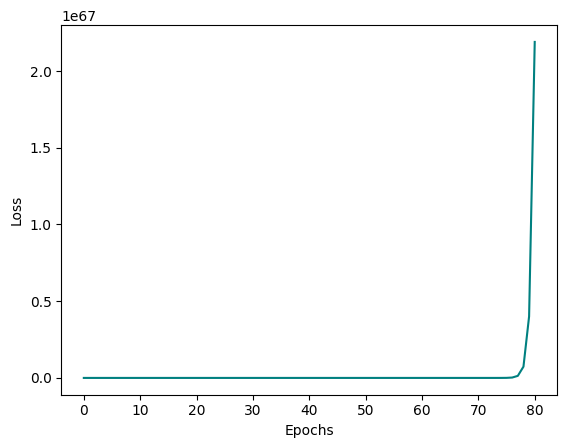

In [55]:
plt.plot(dinn.losses[0:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss'),

NameError: name 'S_pred_list' is not defined

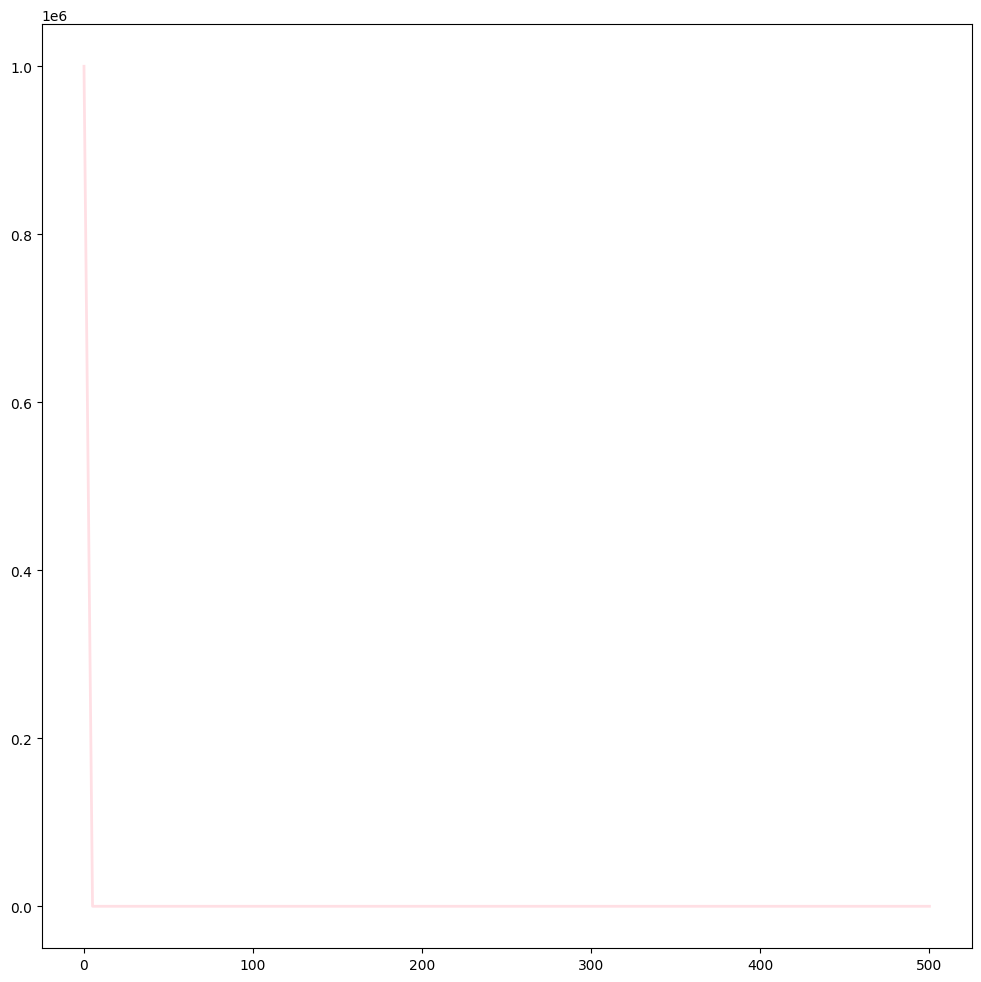

In [56]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.plot(covid_data[0], covid_data[1], 'pink', alpha=0.5, lw=2, label='Susceptible')
ax.plot(covid_data[0], S_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Susceptible Prediction', linestyle='dashed')

ax.plot(covid_data[0], covid_data[2], 'violet', alpha=0.5, lw=2, label='Infected')
ax.plot(covid_data[0], I_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='Infected Prediction', linestyle='dashed')

ax.plot(covid_data[0], covid_data[3], 'darkgreen', alpha=0.5, lw=2, label='Dead')
ax.plot(covid_data[0], D_pred_list[0].detach().numpy(), 'green', alpha=0.9, lw=2, label='Dead Prediction', linestyle='dashed')

ax.plot(covid_data[0], covid_data[4], 'blue', alpha=0.5, lw=2, label='Recovered')
ax.plot(covid_data[0], R_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Recovered Prediction', linestyle='dashed')


ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()